In [1]:
!pip install -U pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 54.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 107.2 MB/s eta 0:00:0000:0100:01


# Processing the dataset and preparing the environment for fine-tuning

In [2]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

from torch.func import vmap

import random
import time

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

from PIL import Image

def create_df(path):
    dd = {"images": [], "labels": []}
    for i in os.listdir(path):
        img_dir = os.path.join(path, i)
        index = 0
        imgs = os.listdir(img_dir)
        random.shuffle(imgs)
        for j in imgs:
            dd["images"] += [os.path.join(img_dir, j)]
            dd["labels"] += [i]
            index += 1
            if index == 1341:
                break

    return pd.DataFrame(dd)

train = create_df("/kaggle/input/pneumonia-radiography-dataset/Radiography/train")
val = create_df("/kaggle/input/pneumonia-radiography-dataset/Radiography/val")
testing = create_df("/kaggle/input/pneumonia-radiography-dataset/Radiography/test")

label_index = {"NORMAL": 0, "PNEUMONIA": 1}
index_label = {0: "NORMAL", 1: "PNEUMONIA"}

train["labels"] = train["labels"].map(label_index)
val["labels"] = val["labels"].map(label_index)
testing["labels"] = testing["labels"].map(label_index)

In [3]:
train = train.values
val = val.values

test = testing.values

In [5]:
EPOCHS = 10
STEP = 10
LR = 0.1
GAMMA = 0.1
IMG_SIZE = 224
BATCH = 16
QLAYERS = 16
OUT_SIZE = len(index_label)

class Pipeline(Dataset):
    def __init__(self, data, transform):
        super(Pipeline, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        
        img, label = self.data[x, 0], self.data[x, 1]

        img = Image.open(img).convert("RGB")
        img = np.array(img)

        img = self.transform(img)
        return img, label

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_ds = Pipeline(train, transform)
val_ds = Pipeline(val, transform)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

dev = qml.device("lightning.qubit", wires=2)

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def qnode(x, params):
    # x: tensor of shape (n_qubits,)
    # Encode classical data by RX rotations
    # print(x.shape)
    # print(x)
    for i in range(2):
        qml.RX(x[i], wires=i)

    # Variational (entangling + rotations)
    for layer in range(params.shape[0]):
        # single-qubit rotations
        for i in range(2):
            qml.Rot(params[layer, i, 0], params[layer, i, 1], params[layer, i, 2], wires=i)
        # simple entangling
        for i in range(2 - 1):
            qml.CNOT(wires=[i, i + 1])
        # optionally wrap-around entanglement
        qml.CNOT(wires=[2 - 1, 0])

    # Measure expectation values (use Z on each qubit)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

# --- A small PyTorch module wrapping the qnode
class QuantumLayer(nn.Module):
    def __init__(self, quantum_layers, n_qubits):
        super().__init__()
        # Initialize params for the variational circuit
        # shape: (n_quantum_layers, n_qubits, 3)
        init = 0.01 * torch.randn(quantum_layers, n_qubits, 3, requires_grad=True)
        self.params = nn.Parameter(init)
        self.qbits = n_qubits
        self.qlayers = quantum_layers

    def forward(self, x):
        # x is a batch of classical features shape (batch, n_qubits)
        outs = []
        for i in range(x.shape[0]):
            out = qnode(x[i], self.params)  # returns list of n_qubits expectations
            outs.append(torch.stack(out))
        # batched_qnode = qml.batch_input(qnode, 0)
        # outputs = batched_qnode(x, self.params, self.qbits, self.qlayers)
        # qnode_vec = vmap(qnode, in_dims=(0, None))
        # outputs = qnode_vec(x, self.params)
        return torch.stack(outs)  # shape (batch, n_qubits)

class ResNet(nn.Module):
    def __init__(self, model, QLAYERS, N_QUBITS):
        super(ResNet, self).__init__()
        self.model = model
        self.qlayer = QuantumLayer(QLAYERS, N_QUBITS)

    def forward(self, x):
        x = self.model(x)
        x = self.qlayer(x)
        x = x.to(torch.float32)
        return nn.functional.softmax(x, dim=1)

resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNet(resnet, 4, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 224MB/s]


# Fine-tuning ResNet50 - training and evaluation log

Epoch 1 train loss 0.036788140456237337 acc 0.5305741983594333 val loss 0.04007406532764435 acc 0.75 time 396.2013883590698
Epoch 2 train loss 0.03300542746080915 acc 0.8866517524235645 val loss 0.03230101615190506 acc 0.9375 time 366.54895758628845
Epoch 3 train loss 0.02644491774612714 acc 0.9780014914243103 val loss 0.030994024127721786 acc 0.875 time 366.84644746780396
Epoch 4 train loss 0.02507840616991056 acc 0.9899328859060402 val loss 0.02971738949418068 acc 0.875 time 363.92919874191284
Epoch 5 train loss 0.024586919703472914 acc 0.9962714392244594 val loss 0.02991005778312683 acc 0.9375 time 365.3839201927185
Epoch 6 train loss 0.024383075351949772 acc 0.9977628635346756 val loss 0.028776206076145172 acc 0.9375 time 369.062460899353
Epoch 7 train loss 0.02421520441481642 acc 0.9996271439224459 val loss 0.028765516355633736 acc 1.0 time 366.09968876838684
Epoch 8 train loss 0.024145551875933705 acc 0.9996271439224459 val loss 0.030447179451584816 acc 0.875 time 363.45796871185

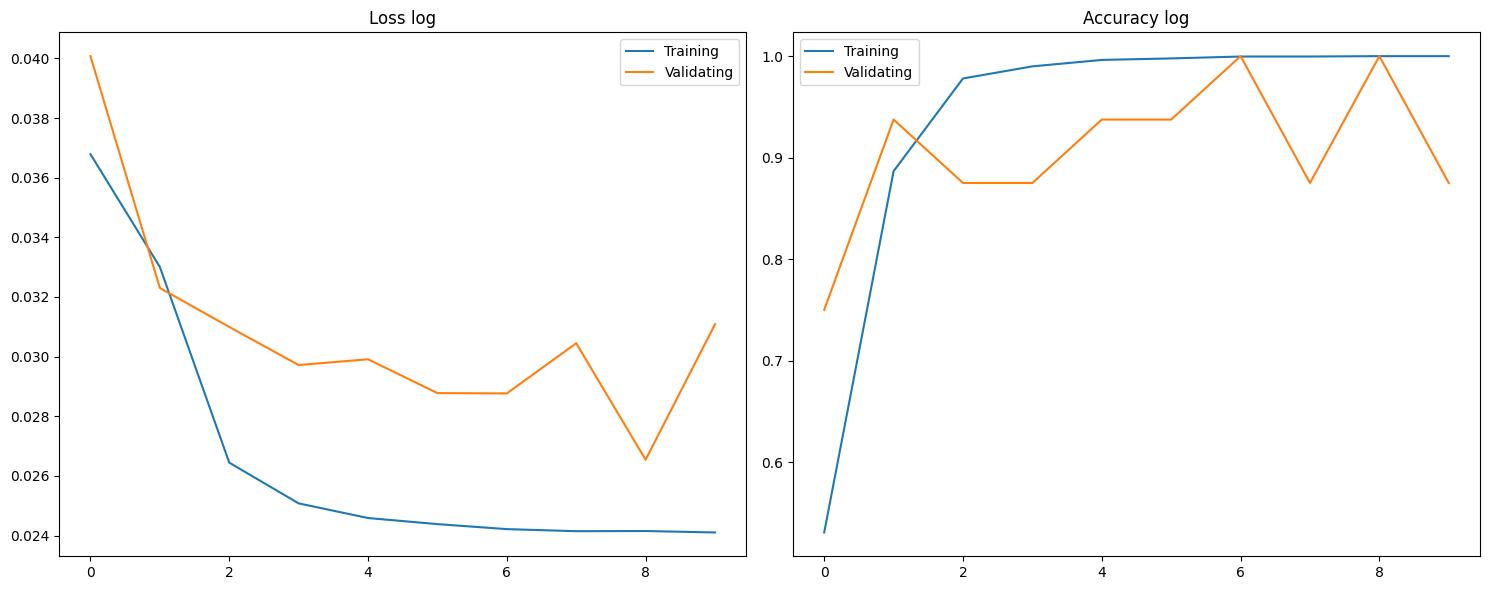

In [6]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

total_start = time.time()

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    acc = 0
    total = 0

    start = time.time()

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        out = model(data)
        # print(out.size())
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)

        loss.backward()
        optimizer.step()

    train_loss += [diff/total]
    train_acc += [acc/total]

    model.eval()

    diff = 0
    acc = 0
    total = 0

    with torch.no_grad():
        for data, target in val_dl:
            optimizer.zero_grad()
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    val_loss += [diff/total]
    val_acc += [acc/total]

    if val_acc[-1] >= best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    end = time.time()

    print("Epoch {} train loss {} acc {} val loss {} acc {} time {}".format(i, train_loss[-1], train_acc[-1],
                                                                   val_loss[-1], val_acc[-1], end - start))

total_end = time.time()

print("Total training time: ", total_end - total_start)

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

axes[index].plot(train_loss, label="Training")
axes[index].plot(val_loss, label="Validating")
axes[index].set_title("Loss log")
axes[index].legend()

index += 1

axes[index].plot(train_acc, label="Training")
axes[index].plot(val_acc, label="Validating")
axes[index].set_title("Accuracy log")
axes[index].legend()
plt.tight_layout()
plt.show()

# Evaluating fine-tuned ResNet50

              precision    recall  f1-score   support

           0       0.70      0.99      0.82       165
           1       1.00      0.78      0.88       320

    accuracy                           0.85       485
   macro avg       0.85      0.89      0.85       485
weighted avg       0.90      0.85      0.86       485



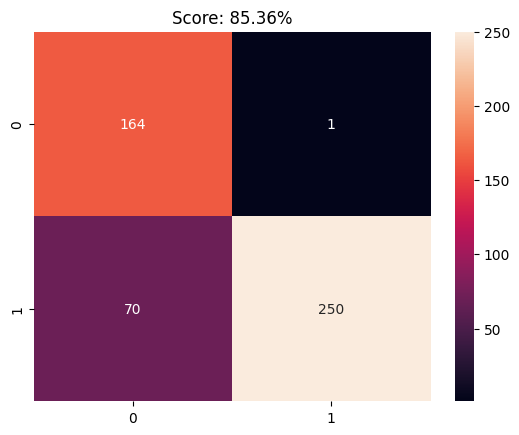

In [16]:
def predict(img):
    img = Image.open(img).convert("RGB")
    img = transform(np.array(img))
    img = img.view([1, 3, 224, 224])

    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        out = best_model(img)

    index = out.argmax(1).item()

    return index, round(out[0][index].item()*100, 2)

truth = []
preds = []
probas = []

np.random.shuffle(test)

for i in range(test.shape[0]):
    truth += [test[i, 1]]
    pred, proba = predict(test[i, 0])
    preds += [pred]
    probas += [proba]

score = accuracy_score(preds, truth)
print(classification_report(preds, truth))
sns.heatmap(confusion_matrix(preds, truth), annot=True, fmt='d')
plt.title("Score: {}%".format(round(score*100, 2)))
plt.show()

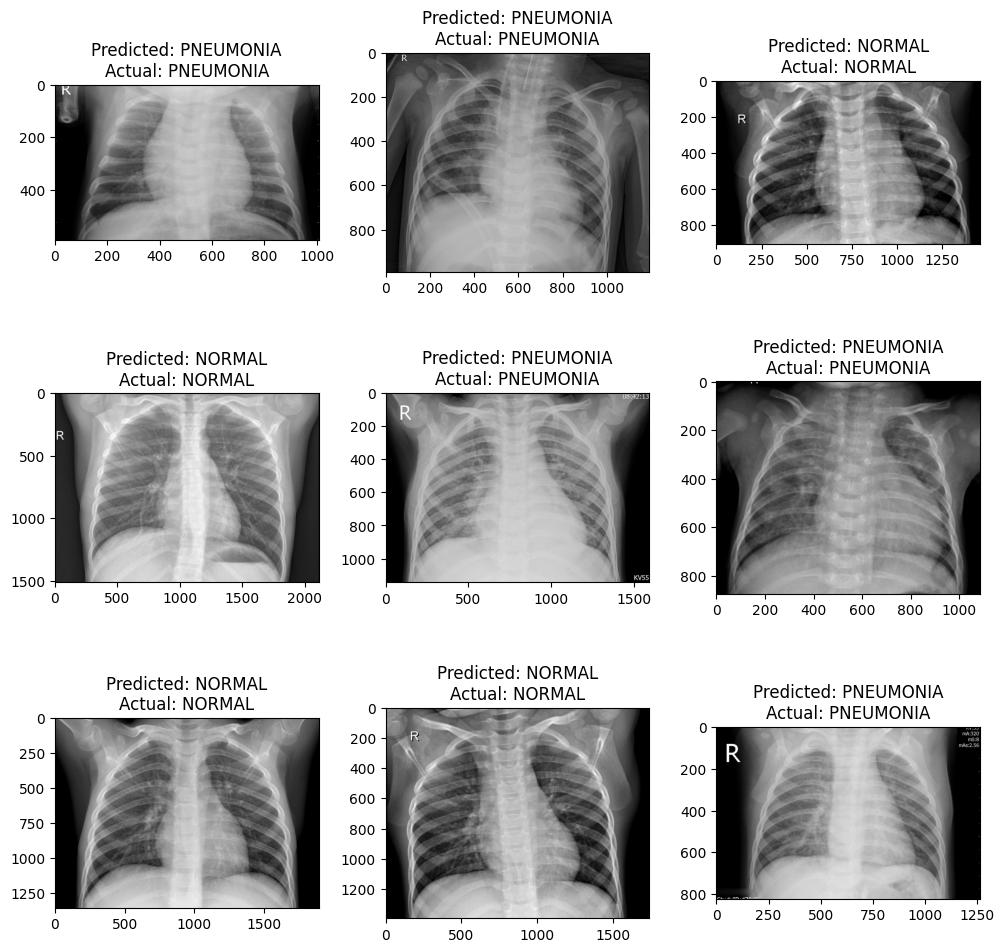

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
index = 0
for i in range(3):
    for j in range(3):
        truth_label = index_label[truth[index]]
        pred_label = index_label[preds[index]]
        image = Image.open(test[index, 0]).convert("RGB")
        axes[i][j].imshow(np.array(image))
        axes[i][j].set_title("Predicted: {}\nActual: {}".format(truth_label, pred_label))
        index += 1
        
plt.tight_layout()
plt.show()

In [18]:
torch.save(best_model, "ResNet_VQC.pt")